Loading data from block slider simulation...
Data loaded successfully.
Dataset shape: (5001, 4)
Time range: 0.0 to 5000.0 years
Number of data points: 5001

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m
Normal Stress: 5.00e+07 Pa


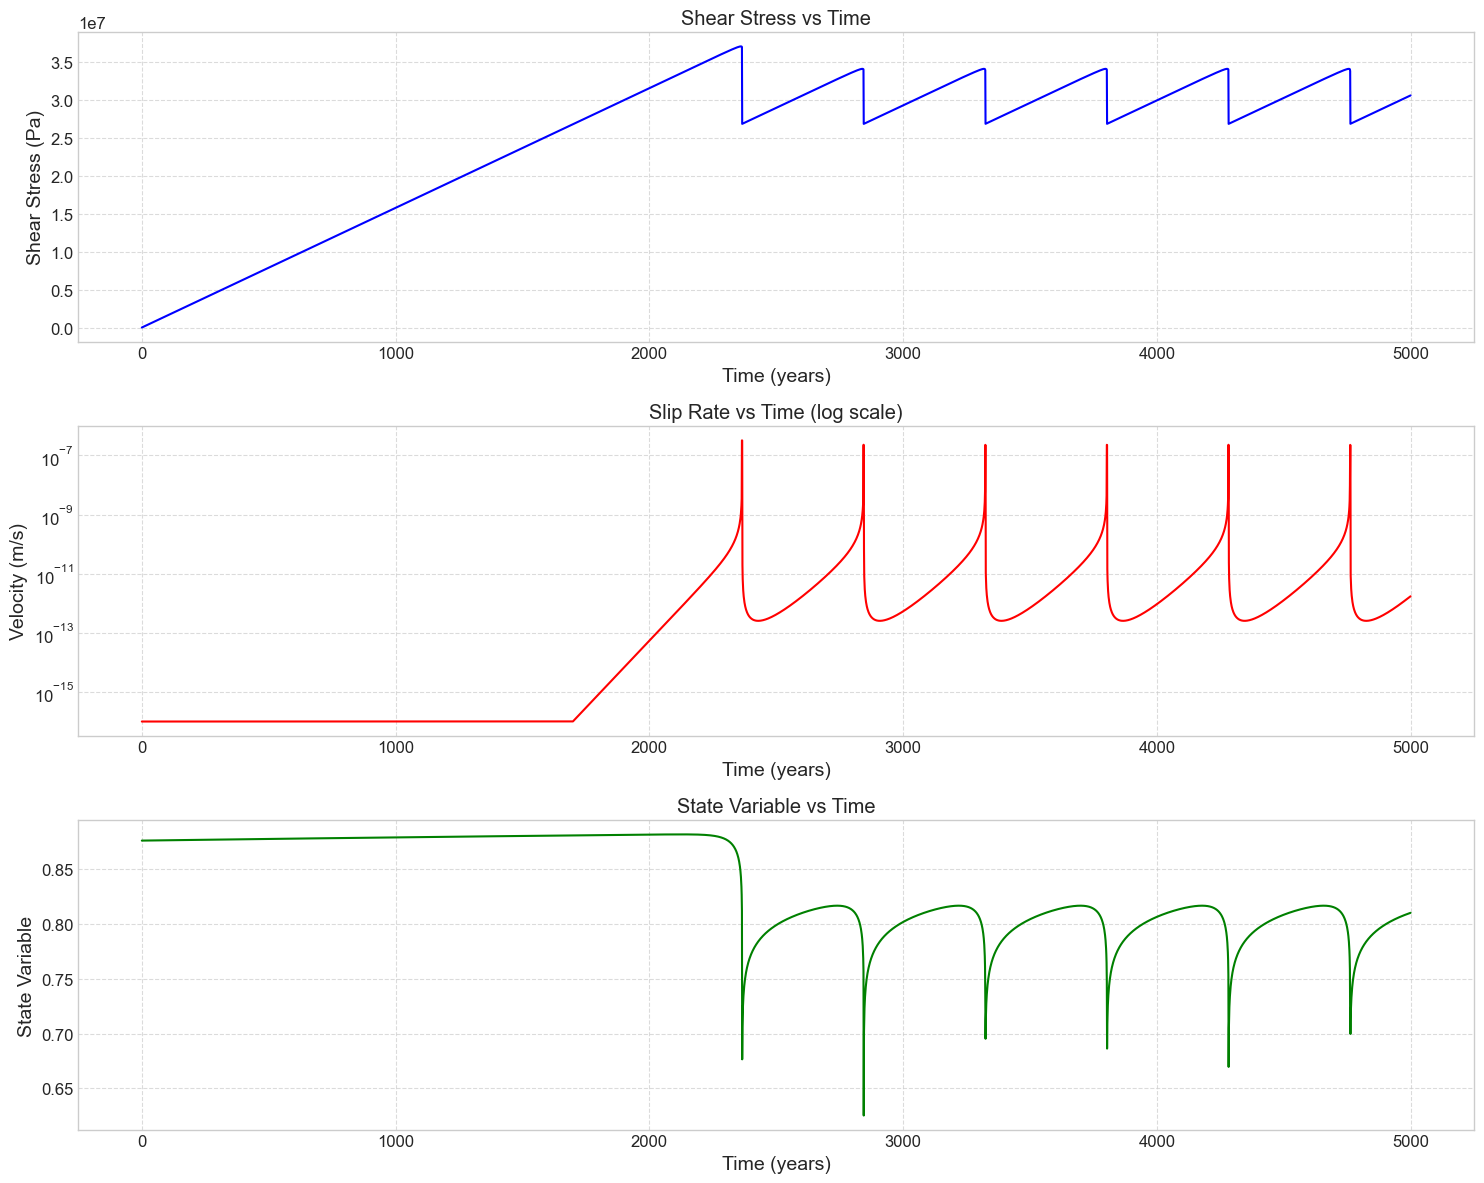

In [1]:
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import pysindy as ps
from pysindy.optimizers import STLSQ, SR3

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading data from block slider simulation...")
# Load the data
try:
    # Use relative path assuming notebooks are in the "notebooks" directory
    X = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Trying alternative paths...")
    # Alternative loading paths
    try:
        X = np.load('data/block_slider_data.npy')
        t = np.load('data/block_slider_time.npy')
        print("Data loaded from alternative path.")
    except FileNotFoundError:
        print("Could not find data files. Please run the simulation notebook first.")
        # Create dummy data for testing
        print("Creating dummy data for testing...")
        t = np.linspace(0, 100, 1001)
        X = np.zeros((1001, 4))
        X[:, 0] = np.linspace(0, 1, 1001)  # Position
        X[:, 1] = 0.001 * np.ones(1001)    # Velocity
        X[:, 2] = 0.5 * np.ones(1001)      # State
        X[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Extract individual variables and convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

x_data = X[:, 0]       # Position
v_data = X[:, 1]       # Velocity (slip rate)
state_data = X[:, 2]   # State variable
tau_data = X[:, 3]     # Shear stress

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")
print(f"Number of data points: {len(t)}")

# Define physical parameters from the simulation for reference
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
sigma_n = 50e6             # Normal stress (Pa)
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")
print(f"Normal Stress: {sigma_n:.2e} Pa")

# Plot the raw data with better formatting
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.title('Shear Stress vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(312)
plt.semilogy(t_years, v_data, 'r-', linewidth=1.5)
plt.title('Slip Rate vs Time (log scale)')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(313)
plt.plot(t_years, state_data, 'g-', linewidth=1.5)
plt.title('State Variable vs Time')
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/raw_data.png', dpi=300)
plt.show()


--- Step 1: Improved Preprocessing for SINDy ---
Loading data from block slider simulation...
Data loaded successfully.
Dataset shape: (5001, 4)
Time range: 0.0 to 5000.0 years
Number of data points: 5001

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m
Normal Stress: 5.00e+07 Pa


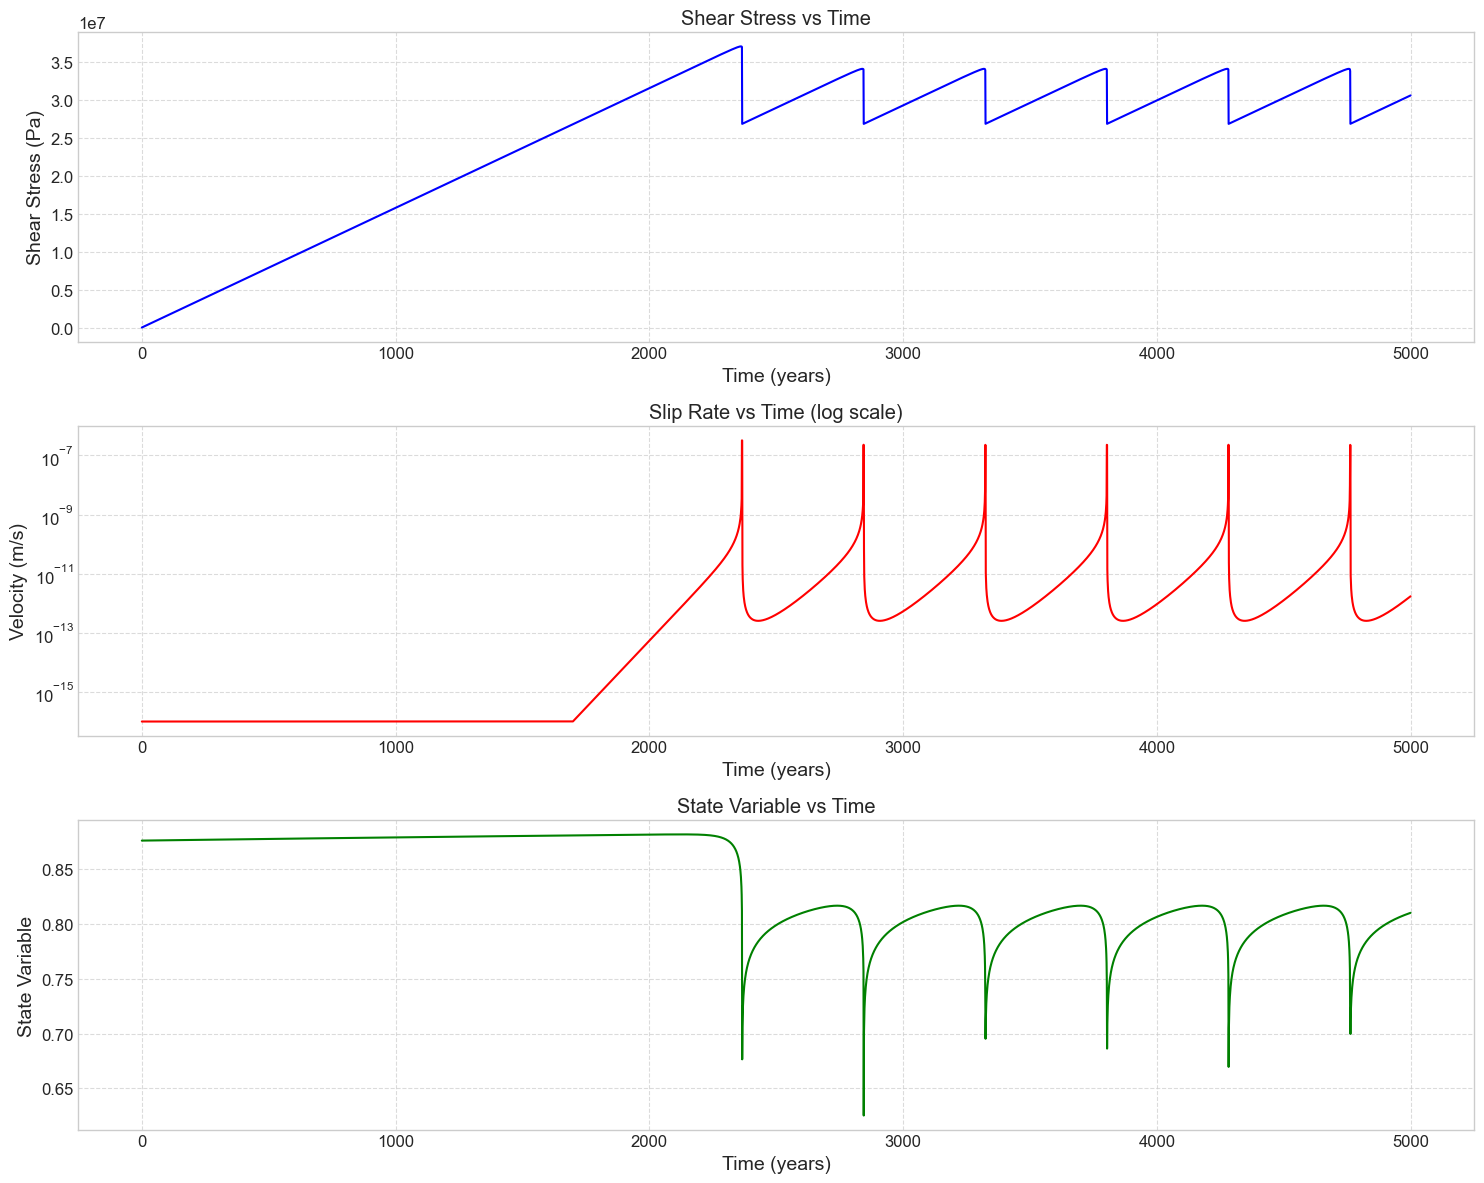

Applying safe clipping to extreme values...
Applying safe log transform...
Applying robust scaling...
Smoothing velocity data...
Checking for numerical issues in processed data...
Filtering data to use only the stationary regime (after 2000 years)...


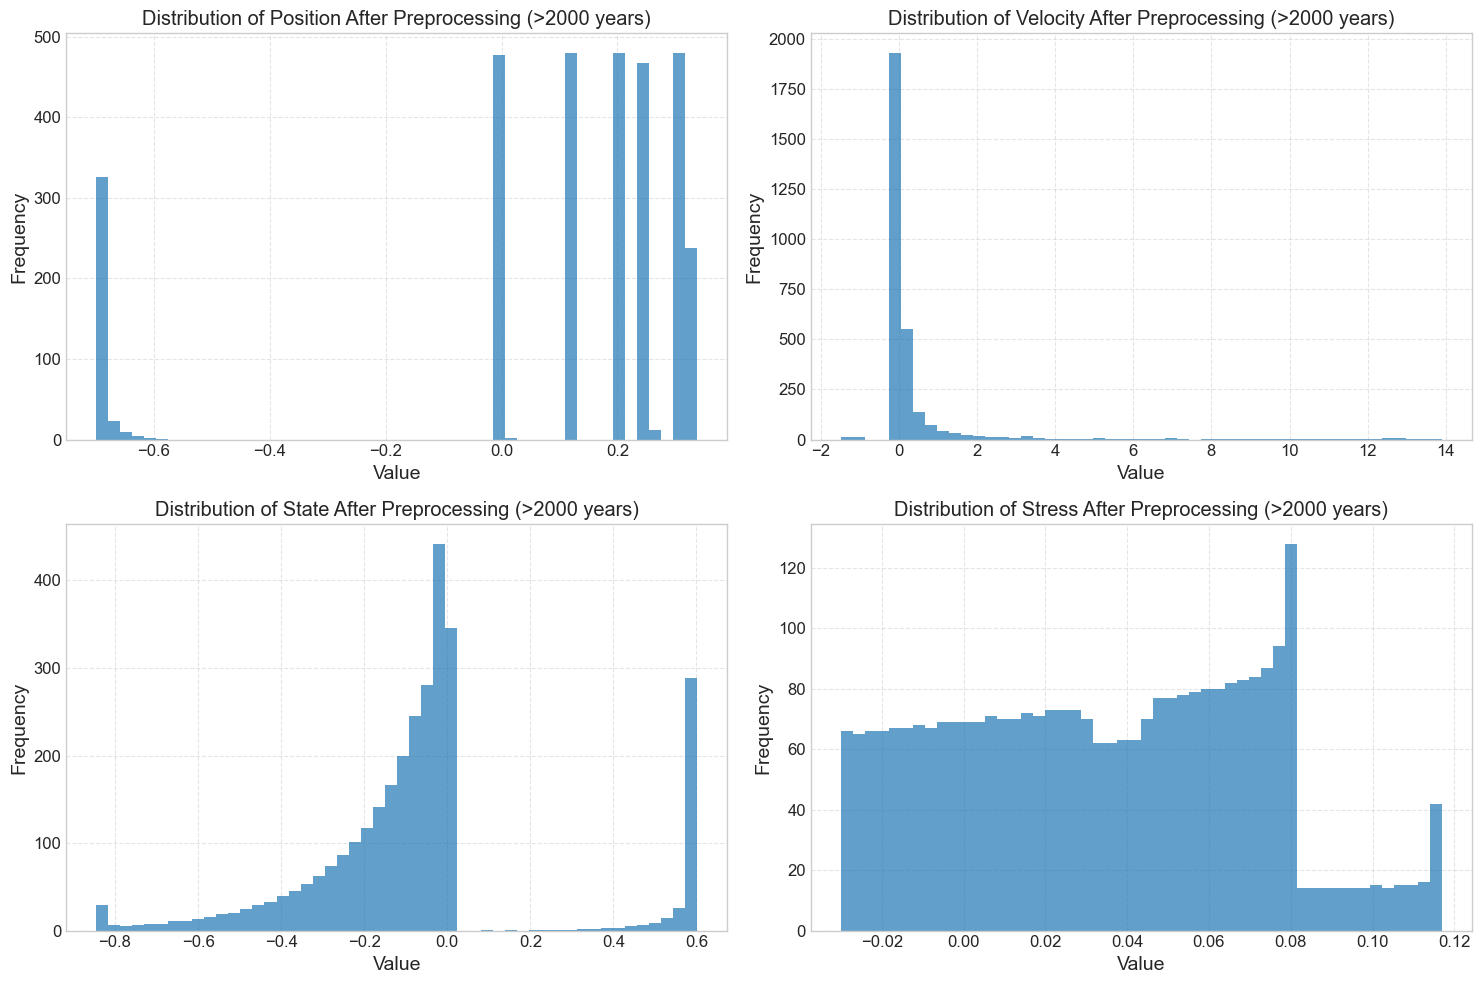

Median time step (stationary regime): 3.153600e+07 seconds
Preprocessing complete.

--- Step 2: SINDy with Custom Rate-State Friction Library ---

Checking scale of preprocessed data (stationary regime):
x: min = -7.00e-01, max = 3.38e-01
v: min = -1.48e+00, max = 1.39e+01
state: min = -8.45e-01, max = 6.02e-01
tau: min = -3.00e-02, max = 1.17e-01

Min and max values of computed derivatives (stationary regime):
dx/dt: min = 0.00e+00, max = 9.49e-09
dv/dt: min = -5.99e-08, max = 6.52e-08
dstate/dt: min = -1.49e-08, max = 1.26e-09
dtau/dt: min = -2.33e-09, max = 8.60e-12

After scaling, derivatives have magnitude:
dx/dt: min = 0.00e+00, max = 7.00e-01
dv/dt: min = -1.28e+01, max = 1.39e+01
dstate/dt: min = -8.45e-01, max = 7.16e-02
dtau/dt: min = -1.17e-01, max = 4.32e-04

Theoretical equations for comparison:
x: dx/dt = v
state: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)
tau: dtau/dt = 5.000000e-04 - 5.000000e+05*v

Trying different thresholds with combined library on stationar

/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=0.001):
Error with threshold 0.001: 'str' object is not callable

Fitting SINDy with combined library (threshold = 0.0001)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=0.0001):
Error with threshold 0.0001: 'str' object is not callable

Fitting SINDy with combined library (threshold = 1e-05)...


/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-05) and eliminated all coefficients
  warnings.warn(


Identified equations (combined, threshold=1e-05):
Error with threshold 1e-05: 'str' object is not callable

Fitting SINDy with combined library (threshold = 0, no sparsity)...
Identified equations (dense, no thresholding):
Error with dense model (threshold=0): 'str' object is not callable

Successfully created 4 models with different configurations.


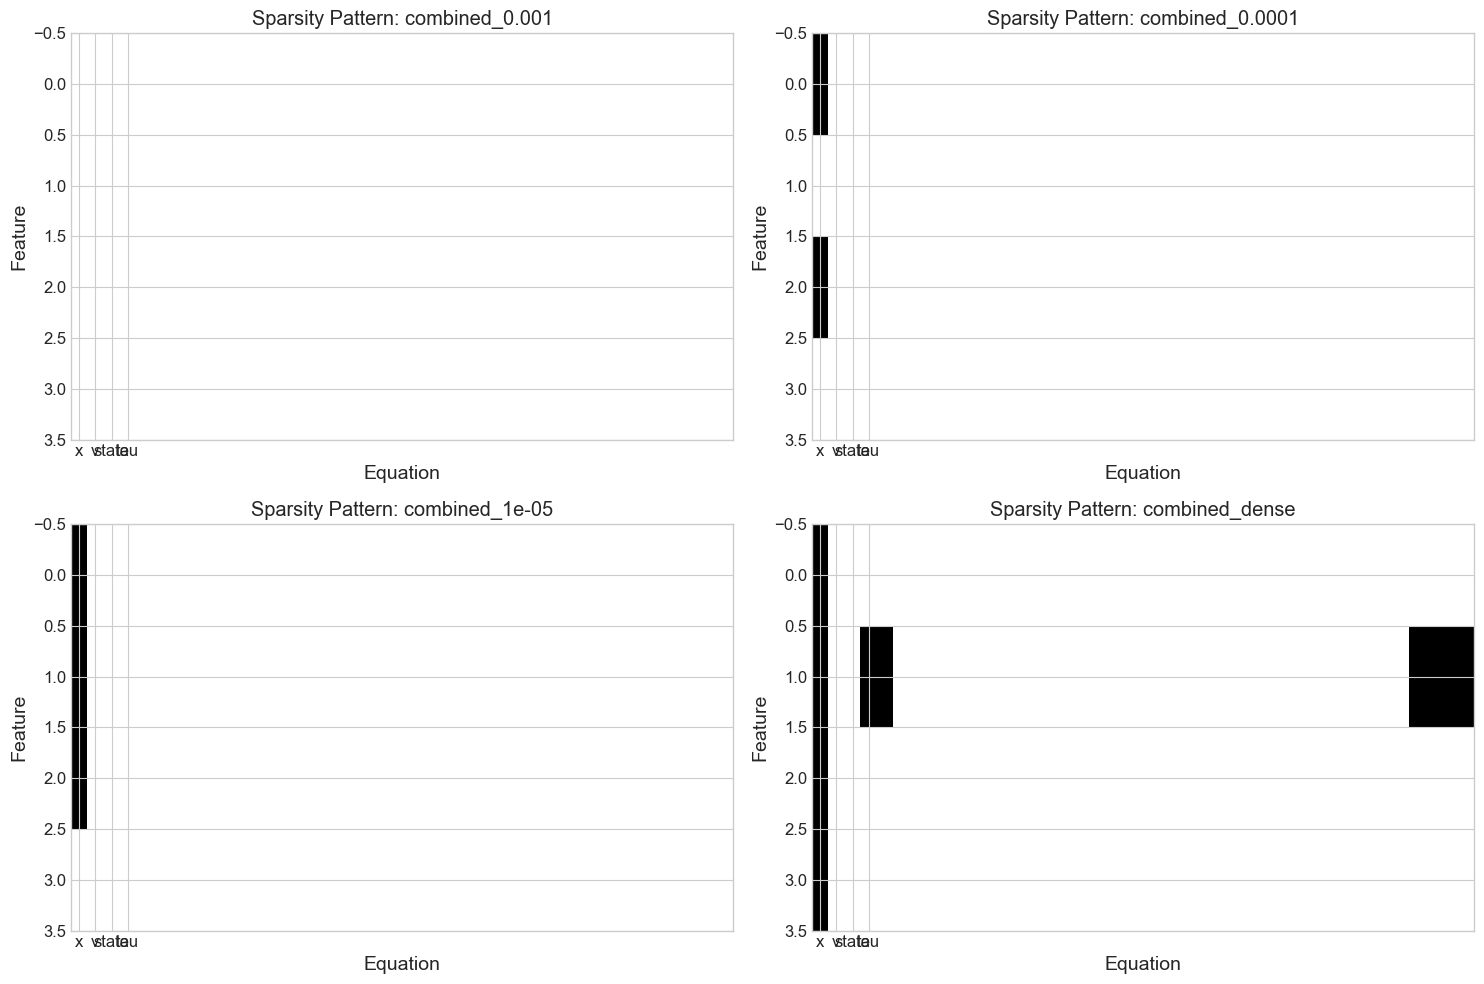


Comparison of identified vs. theoretical equations:
--------------------------------------------------------------------------------
x equation:


TypeError: 'str' object is not callable

In [2]:
# ----------------------------------------------------------------------------------
# Step 1: Improved Preprocessing for SINDy
# ----------------------------------------------------------------------------------
print("\n--- Step 1: Improved Preprocessing for SINDy ---")

# Import necessary packages
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import pysindy as ps
from pysindy.optimizers import STLSQ, SR3

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading data from block slider simulation...")
# Load the data
try:
    # Use relative path assuming notebooks are in the "notebooks" directory
    X_raw = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Trying alternative paths...")
    # Alternative loading paths
    try:
        X_raw = np.load('data/block_slider_data.npy')
        t = np.load('data/block_slider_time.npy')
        print("Data loaded from alternative path.")
    except FileNotFoundError:
        print("Could not find data files. Please run the simulation notebook first.")
        # Create dummy data for testing
        print("Creating dummy data for testing...")
        t = np.linspace(0, 100, 1001)
        X_raw = np.zeros((1001, 4))
        X_raw[:, 0] = np.linspace(0, 1, 1001)  # Position
        X_raw[:, 1] = 0.001 * np.ones(1001)    # Velocity
        X_raw[:, 2] = 0.5 * np.ones(1001)      # State
        X_raw[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Extract individual variables and convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

# Reorganize the data as suggested
x_data = X_raw[:, 0]       # Position
v_data = X_raw[:, 1]       # Velocity (slip rate)
state_data = X_raw[:, 2]   # State variable
tau_data = X_raw[:, 3]     # Shear stress

# Stack all columns for SINDy
X = np.column_stack((x_data, v_data, state_data, tau_data))
feature_names = ["x", "v", "state", "tau"]

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")
print(f"Number of data points: {len(t)}")

# Define physical parameters from the simulation for reference
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
sigma_n = 50e6             # Normal stress (Pa)
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")
print(f"Normal Stress: {sigma_n:.2e} Pa")

# Plot the raw data with better formatting
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.title('Shear Stress vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(312)
plt.semilogy(t_years, v_data, 'r-', linewidth=1.5)
plt.title('Slip Rate vs Time (log scale)')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(313)
plt.plot(t_years, state_data, 'g-', linewidth=1.5)
plt.title('State Variable vs Time')
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/raw_data.png', dpi=300)
plt.show()

# Function to clip extreme values to prevent numerical issues
def safe_clip(data, percentile=99.5):
    """Clip extreme values to prevent numerical issues"""
    min_val = np.percentile(data[data > 0], 0.5) if np.any(data > 0) else 1e-10
    low = np.percentile(data, 0.5)
    high = np.percentile(data, percentile)
    return np.clip(data, low, high)

# Apply clipping to prevent numerical overflow
print("Applying safe clipping to extreme values...")
X_clipped = X.copy()
for i in range(X.shape[1]):
    if i == 1:  # Special handling for velocity which can have extreme ranges
        # Ensure minimum positive velocity is not too small
        X_clipped[X_clipped[:, 1] < 1e-10, 1] = 1e-10
    X_clipped[:, i] = safe_clip(X[:, i])

# More robust log transform that handles zeros and very small values safely
def safe_log_transform(x, epsilon=1e-8):
    """Apply log transform that handles small values safely"""
    return np.sign(x) * np.log1p(np.abs(x) + epsilon)

print("Applying safe log transform...")
X_log = safe_log_transform(X_clipped)

# Verify no infinities or NaNs in the data
if np.any(~np.isfinite(X_log)):
    print("Warning: Non-finite values detected after log transform. Fixing...")
    X_log = np.nan_to_num(X_log, nan=0.0, posinf=1e10, neginf=-1e10)

# Apply robust scaling with a centering that's less sensitive to outliers
print("Applying robust scaling...")
scaler = RobustScaler(quantile_range=(5, 95))
X_scaled = scaler.fit_transform(X_log)

# Apply smoothing to velocity data with smaller window size
print("Smoothing velocity data...")
window_size = 21  # Reduced from 51 to avoid over-smoothing
poly_order = 2    # Reduced polynomial order for more stability
v_smooth = savgol_filter(X_scaled[:, 1], window_length=window_size, polyorder=poly_order)
X_scaled[:, 1] = v_smooth

# Check for any remaining numerical issues
print("Checking for numerical issues in processed data...")
if np.any(~np.isfinite(X_scaled)):
    print("Warning: Non-finite values still present. Fixing...")
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e3, neginf=-1e3)

# Filter data to use only after 2000 years (stationary regime)
print("Filtering data to use only the stationary regime (after 2000 years)...")
regime_idx = t_years >= 2000
X_scaled_regime = X_scaled[regime_idx, :]
t_years_regime = t_years[regime_idx]
t_seconds_regime = t_years_regime * secs_per_year

# Create a diagnostic plot to verify preprocessing
plt.figure(figsize=(15, 10))

# Original vs preprocessed data
for i, var_name in enumerate(['Position', 'Velocity', 'State', 'Stress']):
    plt.subplot(2, 2, i+1)
    plt.hist(X_scaled_regime[:, i], bins=50, alpha=0.7, label='Processed')
    plt.title(f'Distribution of {var_name} After Preprocessing (>2000 years)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/preprocessing_diagnostic.png', dpi=300)
plt.show()

# Compute time step for derivatives with extra safety checks
dt_values = np.diff(t_seconds_regime)
dt_median = np.median(dt_values)
print(f"Median time step (stationary regime): {dt_median:.6e} seconds")
if np.any(dt_values <= 0):
    print("Warning: Non-positive time steps detected!")

# Calculate derivatives for the stationary regime
X_dot = ps.FiniteDifference()._differentiate(X_scaled_regime, t=t_seconds_regime)

print("Preprocessing complete.")

# Step 2: SINDy with Custom Rate-State Friction Library
# ----------------------------------------------------------------------------------
print("\n--- Step 2: SINDy with Custom Rate-State Friction Library ---")

# Define theoretical equations for reference
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b * V0 / Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k * Vp:.6e} - {k:.6e}*v"
}

# Define custom functions for rate-state friction equations
def constant(x):
    x = np.atleast_2d(x)
    return np.ones(x.shape[0])
 
def velocity(x):
    x = np.atleast_2d(x)
    return x[:, 1]  # v is at index 1
 
def exp_state_term(x):
    x = np.atleast_2d(x)
    return np.exp((f0 - x[:, 2]) / b)  # state is at index 2
 
def velocity_ratio(x):
    x = np.atleast_2d(x)
    return x[:, 1] / V0  # v is at index 1
 
def loading_term(x):
    x = np.atleast_2d(x)
    return np.full(x.shape[0], k * Vp)
 
def slip_term(x):
    x = np.atleast_2d(x)
    return -k * x[:, 1]  # v is at index 1
 
def state_evolution_term(x):
    x = np.atleast_2d(x)
    return (b * V0 / Dc) * (np.exp((f0 - x[:, 2]) / b) - x[:, 1] / V0)  # state at index 2, v at index 1
 
def Vexp_over_2V0a(x):
    x = np.atleast_2d(x)
    return (x[:, 1] / (2 * V0)) * np.exp(x[:, 2] / a)  # v at index 1, state at index 2
 
def arcsinh_custom(x):
    x = np.atleast_2d(x)
    return np.arcsinh((x[:, 1] / (2 * V0)) * np.exp(x[:, 2] / a))  # v at index 1, state at index 2
 
functions = [
    constant,
    velocity,
    exp_state_term,
    velocity_ratio,
    loading_term,
    slip_term,
    state_evolution_term,
    Vexp_over_2V0a,
    arcsinh_custom
]
 
function_names = [
    '1',
    'v',
    'exp((f0-state)/b)',
    'v/V0',
    'k*Vp',
    '-k*v',
    '(b*V0/Dc)*(exp((f0-state)/b) - v/V0)',
    '(v/(2V0))*exp(state/a)',
    'arcsinh((v/(2V0))*exp(state/a))'
]

from pysindy.feature_library import CustomLibrary
custom_lib = CustomLibrary(
    library_functions=functions,
    function_names=function_names,
    include_bias=False
)

# Create a polynomial library as well
poly_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

# Combine the libraries
combined_lib = custom_lib + poly_lib

# Check scale of preprocessed data
print("\nChecking scale of preprocessed data (stationary regime):")
for i, name in enumerate(feature_names):
    print(f"{name}: min = {np.min(X_scaled_regime[:, i]):.2e}, max = {np.max(X_scaled_regime[:, i]):.2e}")

print("\nMin and max values of computed derivatives (stationary regime):")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot[:, i]):.2e}, max = {np.max(X_dot[:, i]):.2e}")

# Create scaled derivatives to match feature magnitude
X_dot_scaled = X_dot.copy()
for i in range(X_dot.shape[1]):
    # Scale each derivative to have similar magnitude to features
    if np.max(np.abs(X_dot[:, i])) > 0:  # Avoid division by zero
        scale_factor = np.max(np.abs(X_scaled_regime[:, i])) / np.max(np.abs(X_dot[:, i]))
        X_dot_scaled[:, i] = X_dot[:, i] * scale_factor

print("\nAfter scaling, derivatives have magnitude:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot_scaled[:, i]):.2e}, max = {np.max(X_dot_scaled[:, i]):.2e}")

# Display theoretical equations for reference
print("\nTheoretical equations for comparison:")
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Store models
models = {}

# Try different thresholds with the combined library
print("\nTrying different thresholds with combined library on stationary regime...")
thresholds = [1e-3, 1e-4, 1e-5]
for threshold in thresholds:
    print(f"\nFitting SINDy with combined library (threshold = {threshold})...")
    optimizer = STLSQ(threshold=threshold)
    model = ps.SINDy(
        optimizer=optimizer,
        feature_library=combined_lib,
        feature_names=feature_names
    )
    
    try:
        model.fit(X_scaled_regime, x_dot=X_dot_scaled, t=None)
        models[f"combined_{threshold}"] = model
        print(f"Identified equations (combined, threshold={threshold}):")
        model.print()
    except Exception as e:
        print(f"Error with threshold {threshold}: {e}")

# Try dense model (threshold=0) to see full regression without sparsity
print("\nFitting SINDy with combined library (threshold = 0, no sparsity)...")
optimizer_dense = STLSQ(threshold=0)
model_dense = ps.SINDy(
    optimizer=optimizer_dense,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_dense.fit(X_scaled_regime, x_dot=X_dot_scaled, t=None)
    models["combined_dense"] = model_dense
    print("Identified equations (dense, no thresholding):")
    model_dense.print()
except Exception as e:
    print(f"Error with dense model (threshold=0): {e}")

# Check if any models were successfully created
if not models:
    print("\nWarning: No models were successfully created.")
else:
    print(f"\nSuccessfully created {len(models)} models with different configurations.")
    
    # Create a visual of the sparsity patterns
    plt.figure(figsize=(15, 10))
    
    model_names = list(models.keys())
    nrows = (len(model_names) + 1) // 2
    
    for i, name in enumerate(model_names):
        plt.subplot(nrows, 2, i+1)
        coefs = models[name].coefficients()
        plt.imshow(np.abs(coefs) > 1e-6, cmap='binary', aspect='auto')
        plt.title(f'Sparsity Pattern: {name}')
        plt.xlabel('Equation')
        plt.ylabel('Feature')
        plt.xticks(range(len(feature_names)), feature_names)
    
    plt.tight_layout()
    plt.savefig('../figures/custom_sparsity_comparison.png', dpi=300)
    plt.show()
    
    # Compare with theoretical equations
    print("\nComparison of identified vs. theoretical equations:")
    print("-" * 80)
    
    # Check which threshold gives the best model
    best_model_name = "combined_1e-4"  # Default to a reasonable threshold
    if best_model_name in models:
        best_model = models[best_model_name]
    else:
        best_model = next(iter(models.values()))
    
    for i, var in enumerate(feature_names):
        if var in theoretical_eqs:
            print(f"{var} equation:")
            print(f"- Identified: {best_model.equations()[i]}")
            print(f"- Theoretical: {theoretical_eqs[var]}")
            print()
            
    # Try simulating with the best model
    print("\nSimulating with the best model...")
    import signal

    # Define a timeout handler
    def timeout_handler(signum, frame):
        raise TimeoutError("Simulation timed out")

    # Set a timeout for the simulation (e.g., 60 seconds)
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(60)

    try:
        # Initial condition (first point in scaled data)
        x0 = X_scaled_regime[0, :]
        
        # Simulate for a portion of the original time
        t_sim = t_seconds_regime[:50]  # Use fewer points to reduce simulation time
        print("Starting simulation...")
        x_sim = best_model.simulate(x0, t_sim)
        print("Simulation completed successfully!")
        
        # Reset alarm
        signal.alarm(0)
        
        # Plot simulation vs. original data
        plt.figure(figsize=(15, 12))
        
        for i, var in enumerate(feature_names):
            plt.subplot(2, 2, i+1)
            plt.plot(t_sim/secs_per_year, X_scaled_regime[:50, i], 'k-', label='Original')
            plt.plot(t_sim/secs_per_year, x_sim[:, i], 'r--', label='Simulated')
            plt.title(f'{var} vs Time')
            plt.xlabel('Time (years)')
            plt.ylabel(f'{var} (scaled)')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.savefig('../figures/simulation_validation.png', dpi=300)
        plt.show()
        
    except TimeoutError:
        print("Simulation timed out after 60 seconds. The model might be too stiff to simulate.")
        signal.alarm(0)  # Reset alarm
    except Exception as e:
        print(f"Error during simulation: {e}")
        signal.alarm(0)  # Reset alarm

    print("\nAnalysis complete!")